In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import codedapertures as ca
import scipy as sp
import os
import cv2
from scipy.ndimage.filters import convolve
import time
import pickle

from utils import get_objects_from_config
from experiment import CodApSimulator, play_simulation, plot_results
from image_preprocessing import process_image
from decoding_algorythms import mura_decoding_algorythm

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_6917/279005117.py:9: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


# <center> First attempt on simulating Coded Aperture (DEPRECATED) </center>

This notebook is a first attempt on simulating light coming out of a screen as single photons, passing through a single hole, projecting onto a flat sensor.

The degrees of fredom would be:
1. Distance between each screen
2. Solid angle limits of emision (for now, we fix it at 360 for $\theta$, and 90 for $\phi$)
3. Number of photons coming out of each pixel
4. Resolution: Number of pixels on the light source
5. Dimention of each screen

## Testing Image Prepocessing

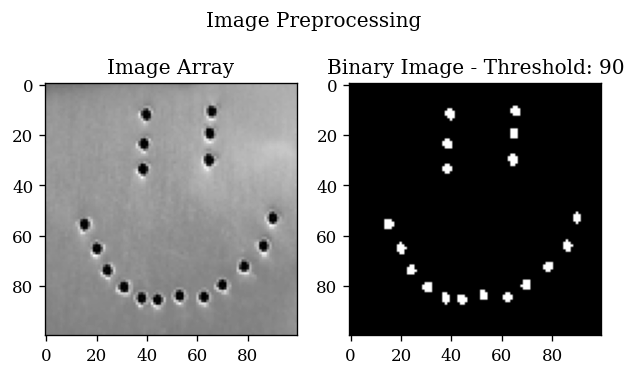

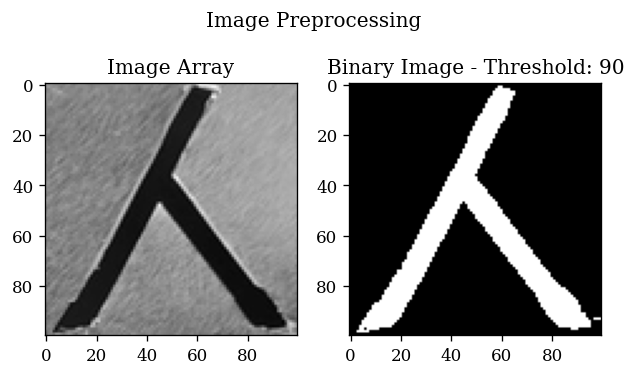

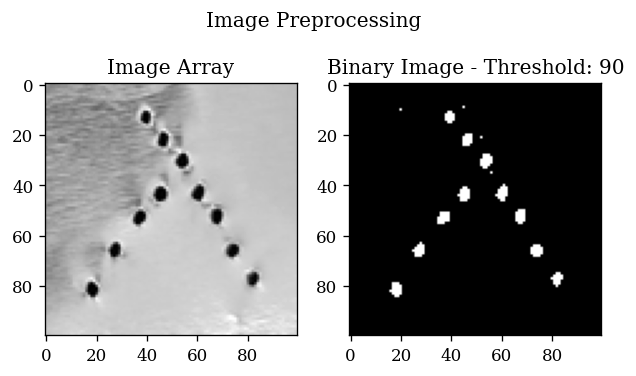

In [3]:
names = ['face_pinhole_exp', 'lambda_letter_srce_exp', 'lambda_letter_pinhole_exp']
for i in range(len(names)):
    binary_img = process_image(names[i], image_type='png', invert = True)

## Testing full pipeline

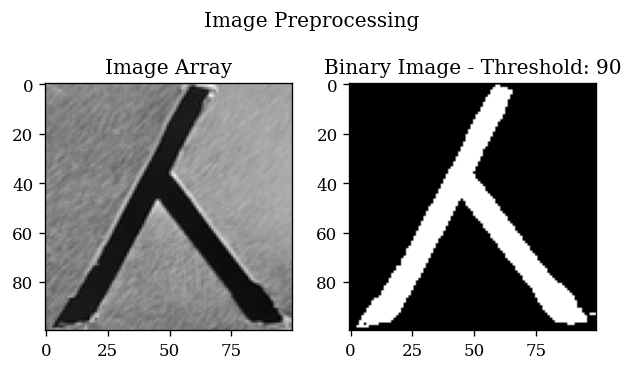

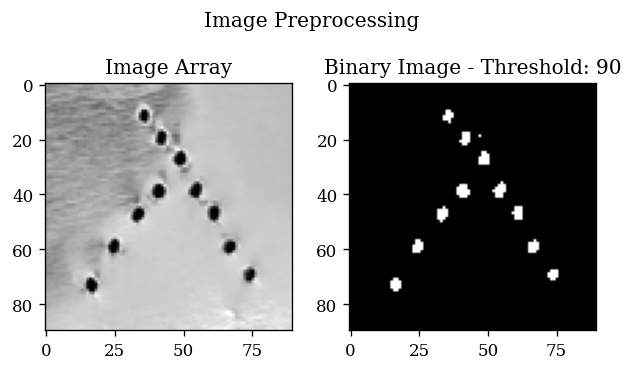

The chosen directory is not empty:
results\Test 2


  1%|          | 307/50000 [00:00<00:35, 1394.02it/s]

Continuing...
Simulating the propagation of photons through the slit...


100%|██████████| 50000/50000 [00:26<00:00, 1876.13it/s]

Adding noise to the image...
Done!
Saving results...


In [13]:
config_path = "config.json"
source, slit, sensor, options = get_objects_from_config(config_path)
simulator = CodApSimulator(options=options, source=source, slit=slit, sensor=sensor)
play_simulation(simulator=simulator, config_path=config_path)

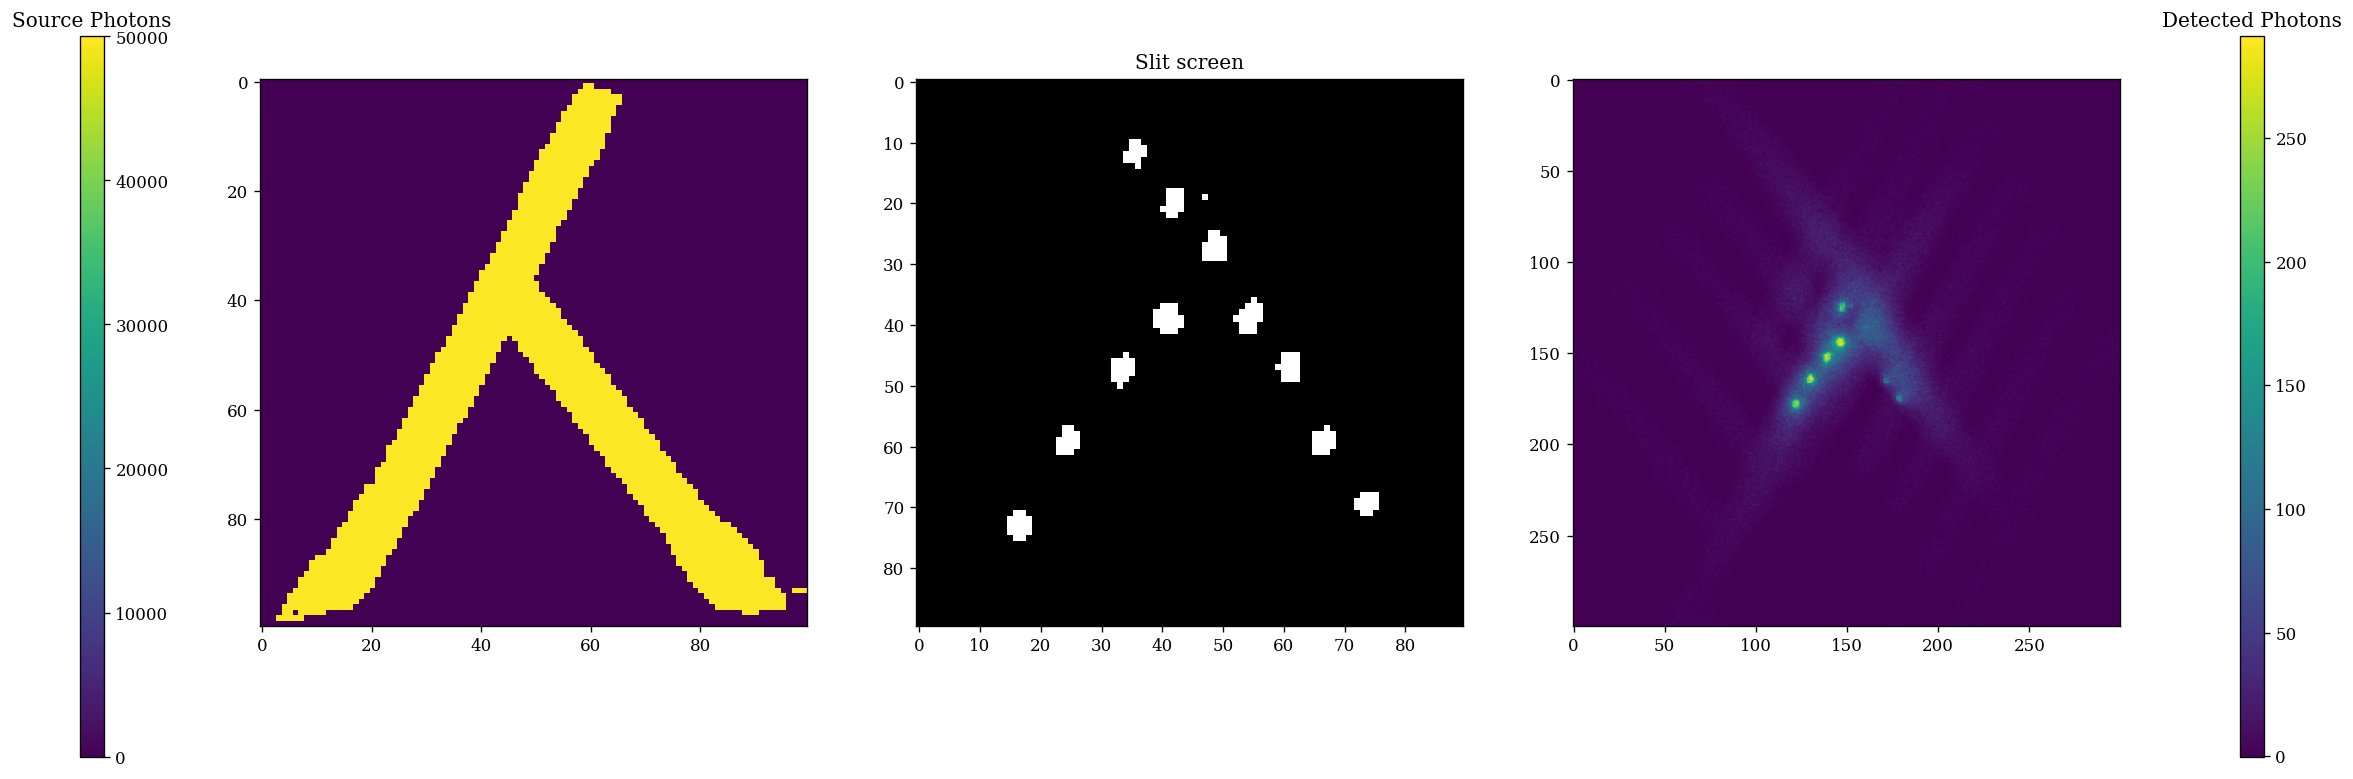

In [14]:
plot_results()

In [30]:
config_path = "config.json"
source, slit, sensor, options = get_objects_from_config(config_path)
simulator = CodApSimulator(options=options, source=source, slit=slit, sensor=sensor)
play_simulation(simulator=simulator, config_path=config_path)

The chosen directory is not empty:
results\Test 2


  1%|          | 122/10000 [00:00<00:08, 1169.39it/s]

Continuing...
Simulating the propagation of photons through the slit...


100%|██████████| 10000/10000 [00:06<00:00, 1649.55it/s]

Adding noise to the image...
Done!
Saving results...


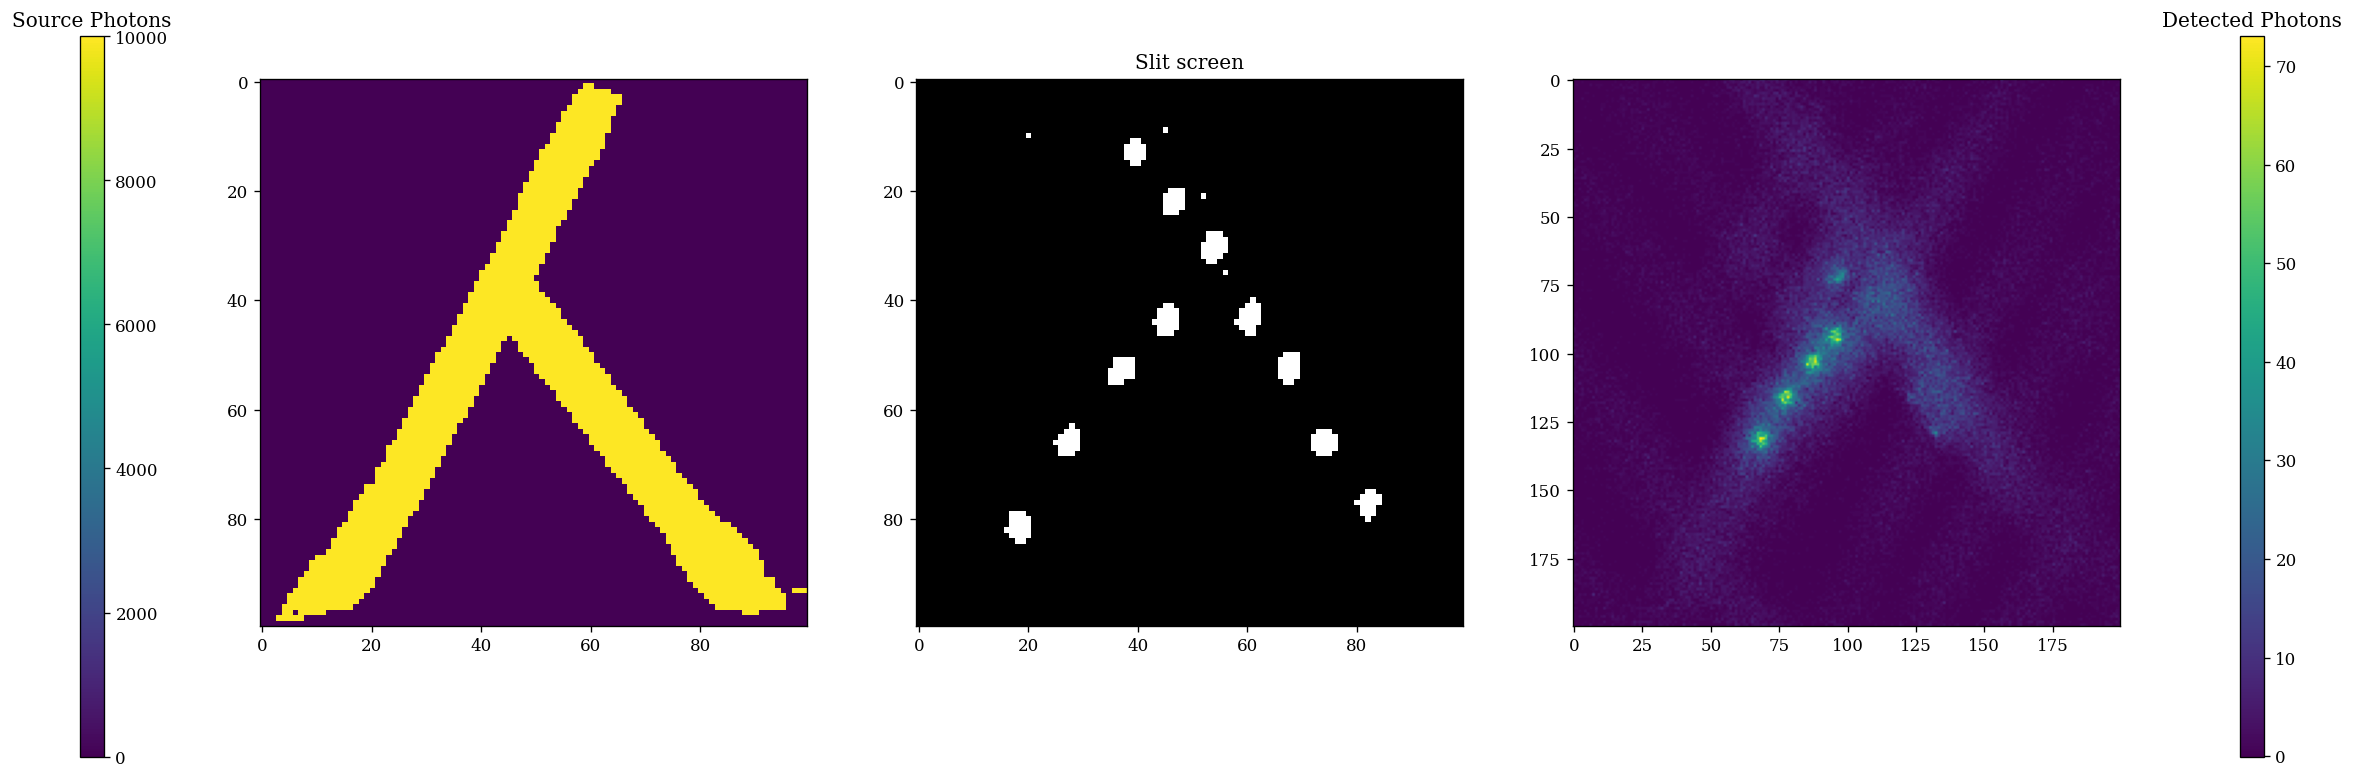

In [31]:
fig = plt.figure(figsize=(20, 20))
plt.subplot(2,3, 1)
vmin, vmax = 0, float(np.max(simulator.source.screen))
im = plt.imshow(simulator.source.screen, vmin=vmin, vmax=vmax)
im = plt.imshow(simulator.source.screen)
cbar_ax = fig.add_axes([0.05, 0.54, 0.01, 0.3])
fig.colorbar(im, cax=cbar_ax)
plt.title("Source Photons")
plt.subplot(2, 3, 2)
plt.imshow(simulator.slit.mask, cmap="binary_r")
plt.title("Slit screen")
plt.subplot(2, 3, 3)
vmin, vmax = 0, float(np.percentile(simulator.sensor.screen, 99.9))
im = plt.imshow(simulator.sensor.screen, vmin=vmin, vmax=vmax)
im = plt.imshow(simulator.sensor.screen)
cbar_ax = fig.add_axes([0.95, 0.54, 0.01, 0.3])
fig.colorbar(im, cax=cbar_ax)
plt.title("Detected Photons")
plt.savefig(os.path.join(simulator.saving_dir, "results.png"))

## Testing Decoding

### MURA

In [3]:
config_path = 'mura_experiment.json'
source, slit, sensor, options = get_objects_from_config(config_path=config_path)
simulator = CodApSimulator(source=source, slit=slit, sensor=sensor, options=options)

Modified Uniformly Redundant Array
----------------------------------
rank:   11
L:      101
tile:   (1, 1)
width:  101
height: 101
The chosen directory is not empty:
results/phi | mura | skipper 2
Continuing...


In [4]:
play_simulation(simulator=simulator, config_path=config_path)

Simulating the propagation of photons through the slit...


100%|██████████| 10000/10000 [00:03<00:00, 2823.08it/s]


Adding noise to the image...
decoding mura image...
Done!
Saving results...


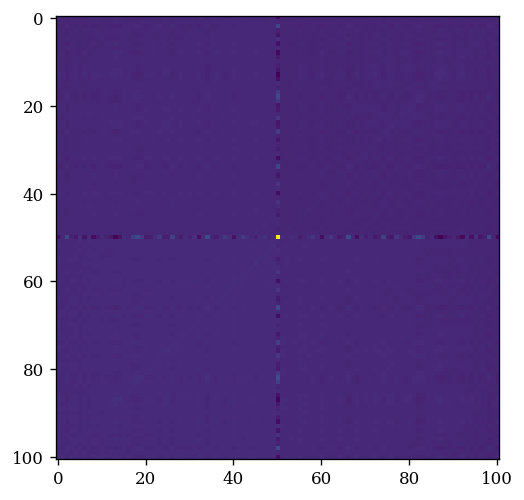

In [19]:
plt.imshow(sp.signal.correlate(simulator.slit.mask, simulator.decoding_pattern, mode='same'))

Modified Uniformly Redundant Array
----------------------------------
rank:   2
L:      17
tile:   (1, 1)
width:  17
height: 17


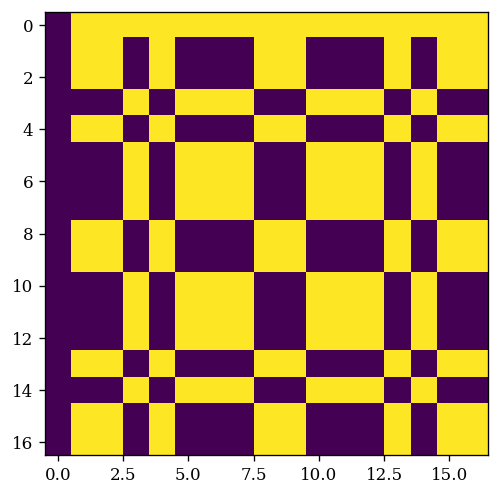

In [32]:
mura = ca.mura(rank=2, tile=1)
plt.imshow(mura.aperture)

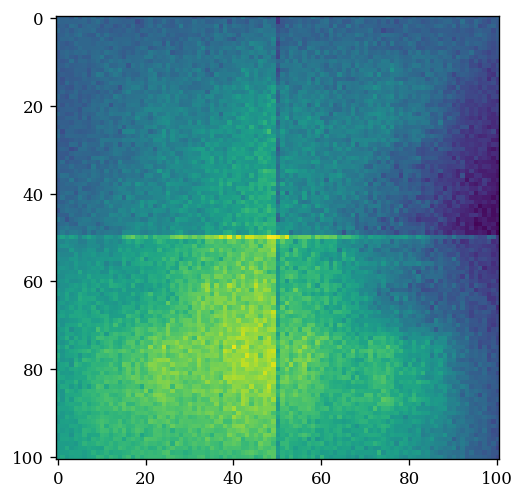

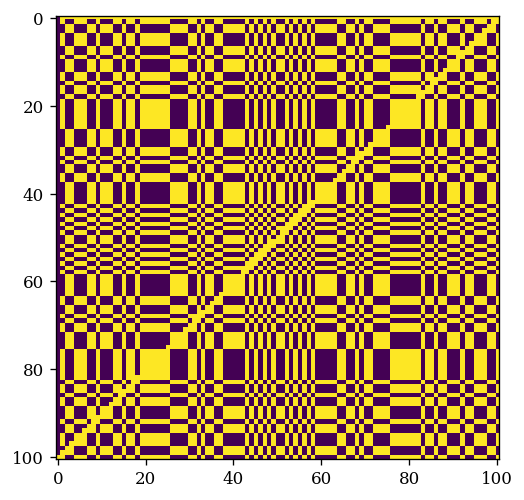

In [18]:
plt.imshow(sp.signal.correlate(simulator.sensor.screen, simulator.decoding_pattern, mode='same'))
plt.show()
plt.imshow(simulator.decoding_pattern)

### Inverse Filering ([image restoration with inverse filtering](https://vkhoi.github.io/notes/image-restoration-with-inverse-filtering))

In [6]:
# Display grayscale image.
def displayImage(img):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img, cmap='gray')

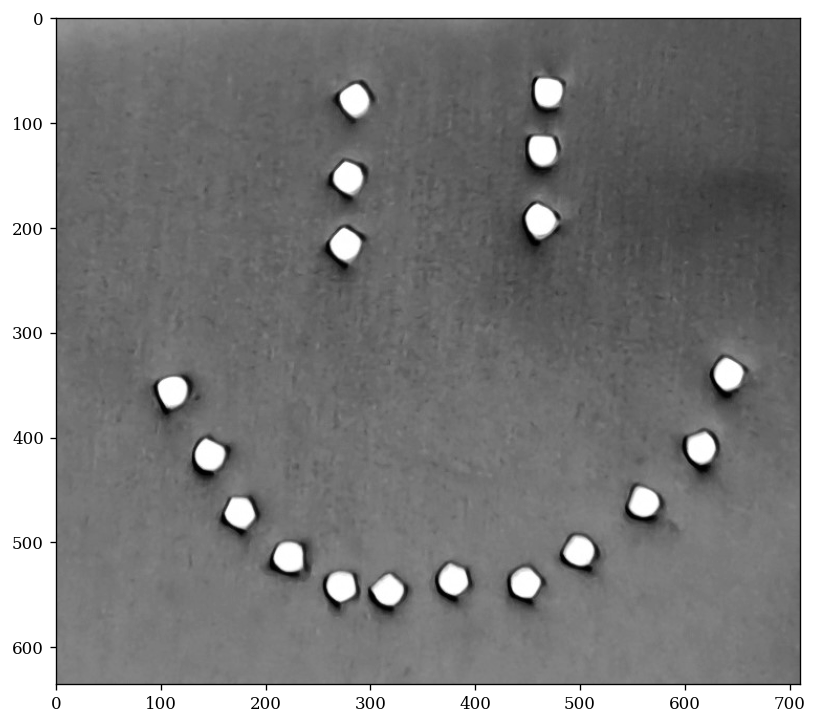

In [7]:
# Input image.
IMAGE_NAME = 'exp_pics/face_pinhole_exp.png'
img = cv2.imread(IMAGE_NAME, 0)
# Invert image.
img = 255 - img

# Display image.
displayImage(img)

Modified Uniformly Redundant Array
----------------------------------
rank:   4
L:      37
tile:   (1, 1)
width:  37
height: 37


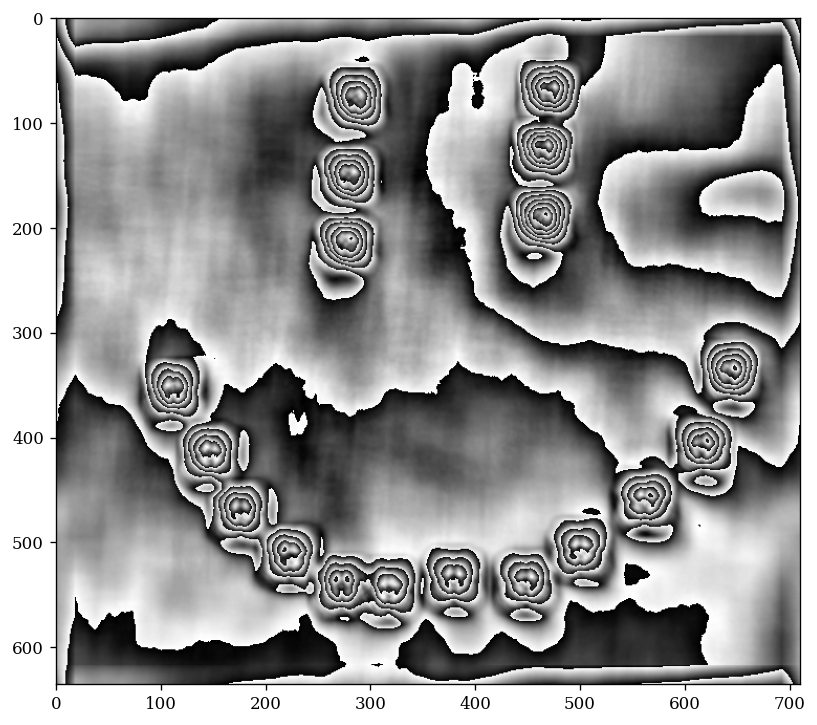

In [26]:
H = 37 # Height of the image.
mura = ca.mura(rank=4, tile=None, center=True)
h = mura.aperture / H

# Apply onto the image.
g = convolve(img, h, mode='wrap')
displayImage(g)

In [28]:
decoding_pattern = np.zeros(h.shape)
for i in range(mura.aperture.shape[0]):
            for j in range(mura.aperture.shape[1]):
                cent_i = int(i - (mura.aperture.shape[0]-1)/2)
                cent_j = int(j - (mura.aperture.shape[1]-1)/2)
                decoding_pattern[i, j] = mura_decoding_algorythm(
                    mura.aperture[i, j], cent_i, cent_j
                )
decoding_pattern /= H
reconstructed_image = convolve(img, decoding_pattern, mode='wrap')

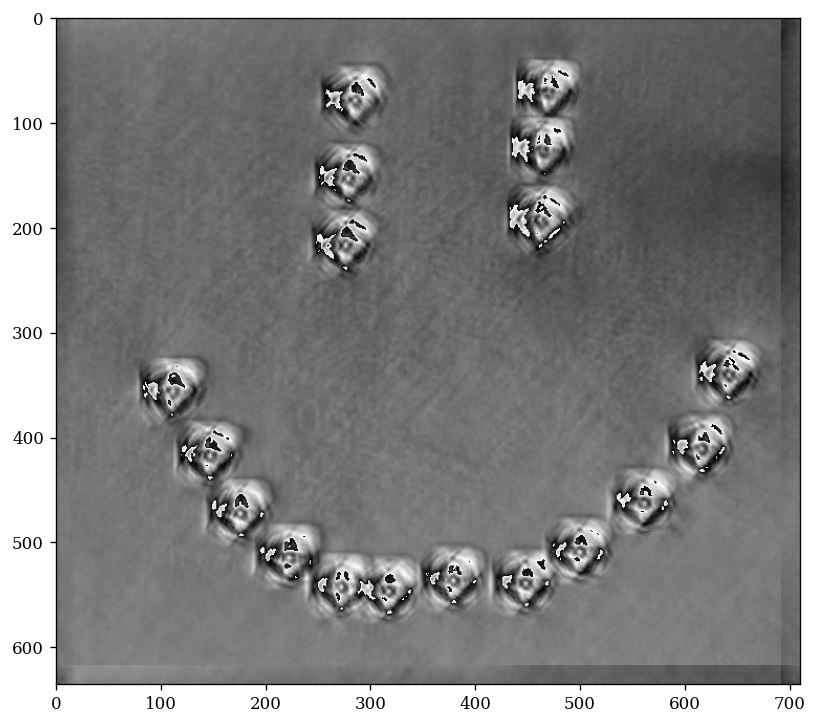

In [29]:
displayImage(reconstructed_image)

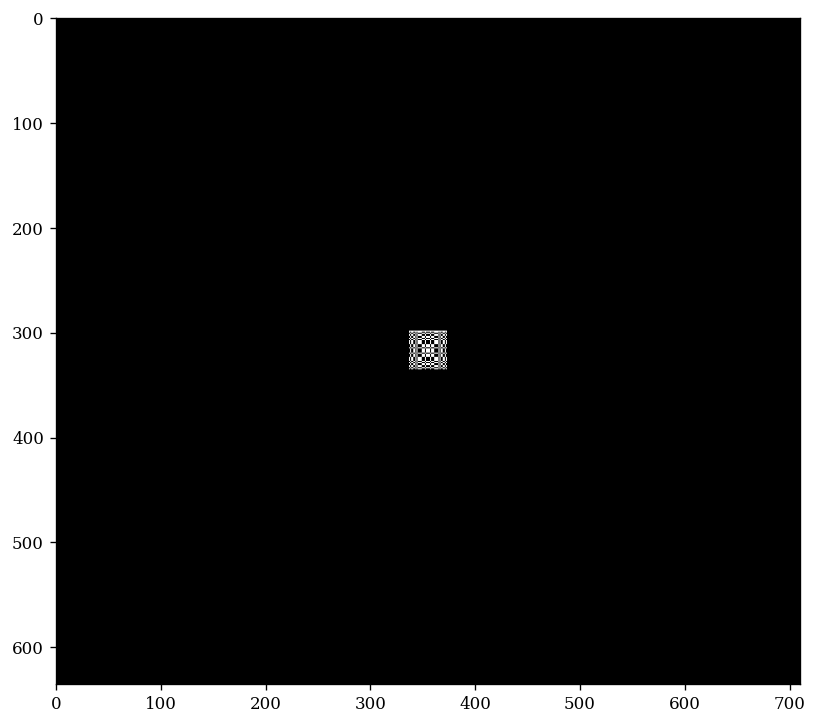

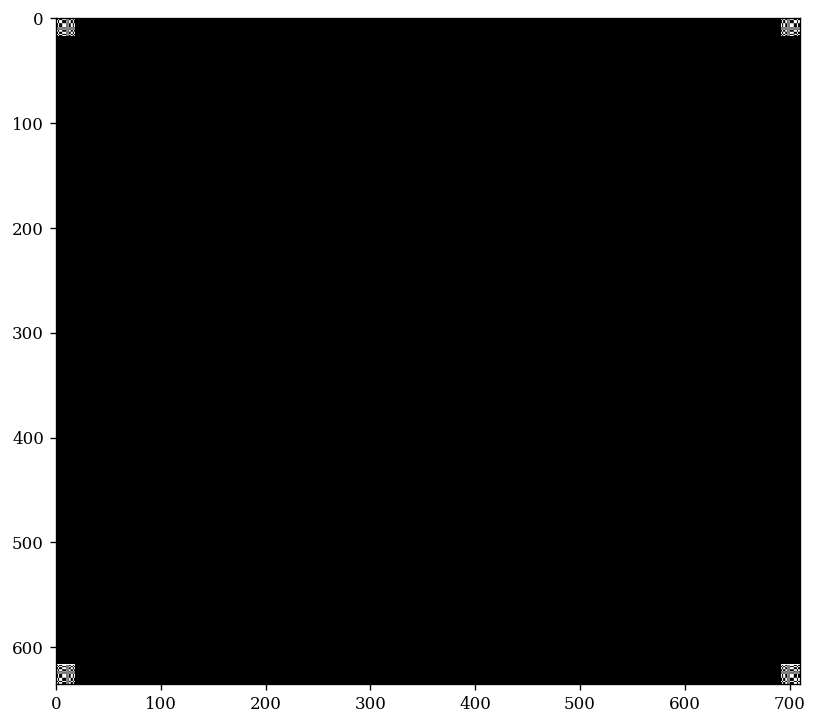

In [10]:
M = g.shape[0]
N = g.shape[1]

# Pad the filter with 0.
h_pad = np.zeros((M, N))
h_pad[(M-h.shape[0])//2:(M-h.shape[0])//2+h.shape[0],(N-h.shape[1])//2:(N-h.shape[1])//2+h.shape[1]] = h
displayImage(h_pad)

# Shift the filter so that its center lies at the first element, aka H[0,0].
h_pad = sp.fftpack.ifftshift(h_pad)
displayImage(h_pad)

In [37]:
G = sp.fftpack.fft2(g)
H = sp.fftpack.fft2(h_pad)

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_41826/2595350236.py:5: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  H_inv = np.zeros(G.shape, dtype=np.complex)


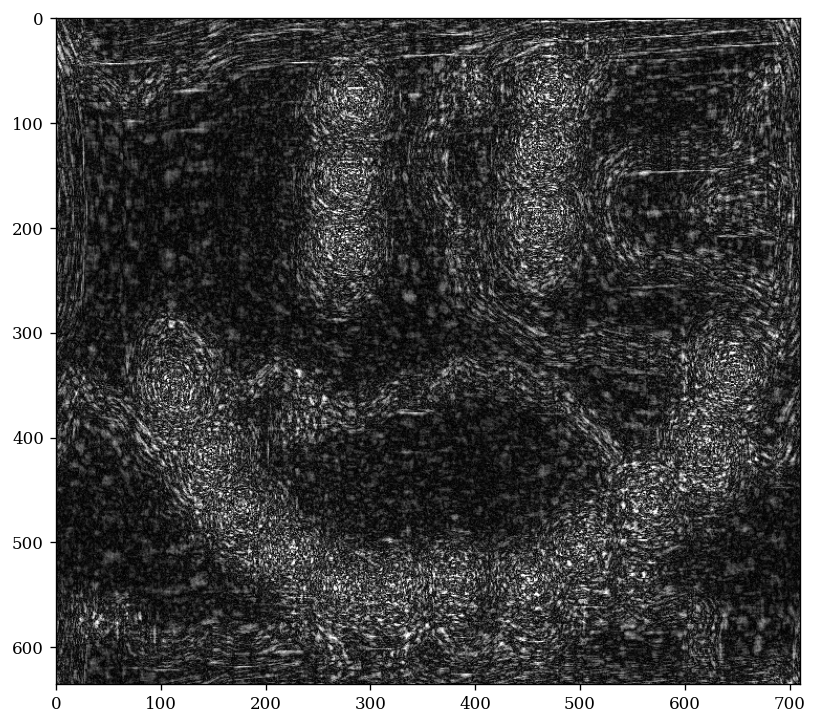

In [46]:
# Set threshold to 0.005.
threshold = 0.35

# Create array to store the pseudo-inverse filter.
H_inv = np.zeros(G.shape, dtype=np.complex)

for r in range(H.shape[0]):
    for c in range(H.shape[1]):
    	# Compute the magnitude and compare it with threshold.
        mag = np.abs(H[r,c])
        if mag <= threshold:
            H_inv[r,c] = 0
        else:
            H_inv[r,c] = 1.0 / H[r,c]

# Compute the approximated Fourier transform of the original image.
F = G * H_inv

# Inverse the Fourier transform to get the original image.
f = scipy.fftpack.ifft2(F)
f = np.abs(f)

# Some values are larger than 255, so we clamp it to 255.
for r in range(f.shape[0]):
    for c in range(f.shape[1]):
        if f[r,c] > 255:
            f[r,c] = 255
displayImage(f)

## Image Generation Simulation by Convolution

In [24]:
def zoom_out_image(image: np.ndarray, zoom_out_factor: float):
    """
    Zooms out an image by a factor of zoom_out_factor, by taking the average of blocks of pixels, 
    and then zero padding the edges to take it back to the original size.

    Parameters
    ----------
    image : np.ndarray
        The image to be zoomed out
    zoom_out_factor : int
        The factor by which the image should be zoomed out. Must be an integer greater than 1.

    Returns
    -------
    np.ndarray
        The zoomed out image
    """
    
    # Calculate the new dimensions
    new_rows = image.shape[0] // zoom_out_factor
    new_cols = image.shape[1] // zoom_out_factor

    # Create an empty image with the new dimensions
    downsampled_image = np.empty((new_rows, new_cols), dtype=image.dtype)

    # Populate the downsampled image by taking the average of blocks from the original image
    for i in range(new_rows):
        for j in range(new_cols):
            block = image[i * zoom_out_factor:(i + 1) * zoom_out_factor,
                        j * zoom_out_factor:(j + 1) * zoom_out_factor]
            downsampled_image[i, j] = np.mean(block)

    # Zero pad the edges to take the downsampled image back to the original size, centering it
    padded_image = np.zeros_like(image)

    # Calculate the starting and ending indices for the padded image
    start_row = (padded_image.shape[0] - downsampled_image.shape[0]) // 2
    end_row = start_row + downsampled_image.shape[0]
    start_col = (padded_image.shape[1] - downsampled_image.shape[1]) // 2
    end_col = start_col + downsampled_image.shape[1]

    # Place the downsampled image in the padded image
    padded_image[start_row:end_row, start_col:end_col] = downsampled_image

    # Plot the downsampled image
    plt.imshow(padded_image)
    return padded_image

def compare_simulation_to_convolution(
        source: np.ndarray,
        slit: np.ndarray,
        slit_to_sensor_distance: float,
        source_to_sensor_distance: float
):
    """
    From a given ran simulation, calculate the image generation as a convolution of the source and the slit,
    and compare the two images.
    After, performs the convolution of the image with the decoding pattern, and compares it
    with the decoded image from the simulation.

    Parameters
    ----------
    source : np.ndarray
        The source image
    slit : np.ndarray
        The slit mask
    slit_to_sensor_distance : float
        The distance between the slit and the sensor
    source_to_sensor_distance : float
        The distance between the source and the sensor
    """
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    # Rescaling the source to the same shape, but zooming out 101 times
    zoom_factor = int(source_to_sensor_distance / slit_to_sensor_distance)
    zoomed_out_source = zoom_out_image(source, zoom_factor)

    # Plot image
    im0 = axs[0, 0].imshow(source)
    axs[0, 0].set_title("Source Image")
    fig.colorbar(im0, ax=axs[0, 0])

    # Plot zoomed out image
    im1 = axs[1, 0].imshow(zoomed_out_source)
    axs[1, 0].set_title("Zoomed Out Source Image")
    fig.colorbar(im1, ax=axs[1, 0])

    image = convolve(zoomed_out_source, slit, mode='wrap')

    reconstructed_image = convolve(image, simulator.decoding_pattern, mode='wrap')

    # Reshape the reconstructed_image so that it matches the shape of the sensor
    reconstructed_image = reconstructed_image[
        (reconstructed_image.shape[0] - simulator.sensor.screen.shape[0]) // 2:
        (reconstructed_image.shape[0] - simulator.sensor.screen.shape[0]) // 2 + simulator.sensor.screen.shape[0],
        (reconstructed_image.shape[1] - simulator.sensor.screen.shape[1]) // 2:
        (reconstructed_image.shape[1] - simulator.sensor.screen.shape[1]) // 2 + simulator.sensor.screen.shape[1]
    ]
    # Reshape the image so that it matches the shape of the sensor
    image = image[
        (image.shape[0] - simulator.sensor.screen.shape[0]) // 2:
        (image.shape[0] - simulator.sensor.screen.shape[0]) // 2 + simulator.sensor.screen.shape[0],
        (image.shape[1] - simulator.sensor.screen.shape[1]) // 2:
        (image.shape[1] - simulator.sensor.screen.shape[1]) // 2 + simulator.sensor.screen.shape[1]
    ] 

    im2 = axs[0, 1].imshow(image)
    axs[0, 1].set_title("Convolved Image")
    fig.colorbar(im2, ax=axs[0, 1])

    axs[0, 2].imshow(simulator.sensor.screen)
    axs[0, 2].set_title("Simulated Image")
    im3 = axs[0, 2].imshow(simulator.sensor.screen)
    fig.colorbar(im3, ax=axs[0, 2])

    im4 = axs[1, 1].imshow(reconstructed_image)
    axs[1, 1].set_title("Decoded Convolved Image")
    fig.colorbar(im4, ax=axs[1, 1])

    im5 = axs[1, 2].imshow(simulator.decoded_image)
    axs[1, 2].set_title("Decoded Simulated Image")
    fig.colorbar(im5, ax=axs[1, 2])

    fig.suptitle(f'Distance relation: {zoom_factor}:1 (source_to_sensor:slit_to_sensor)', fontsize=20)
    
    # Adjust the layout to make room for colorbars
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    return zoomed_out_source, image, reconstructed_image

### Pinhole Source 101:1 Relationship

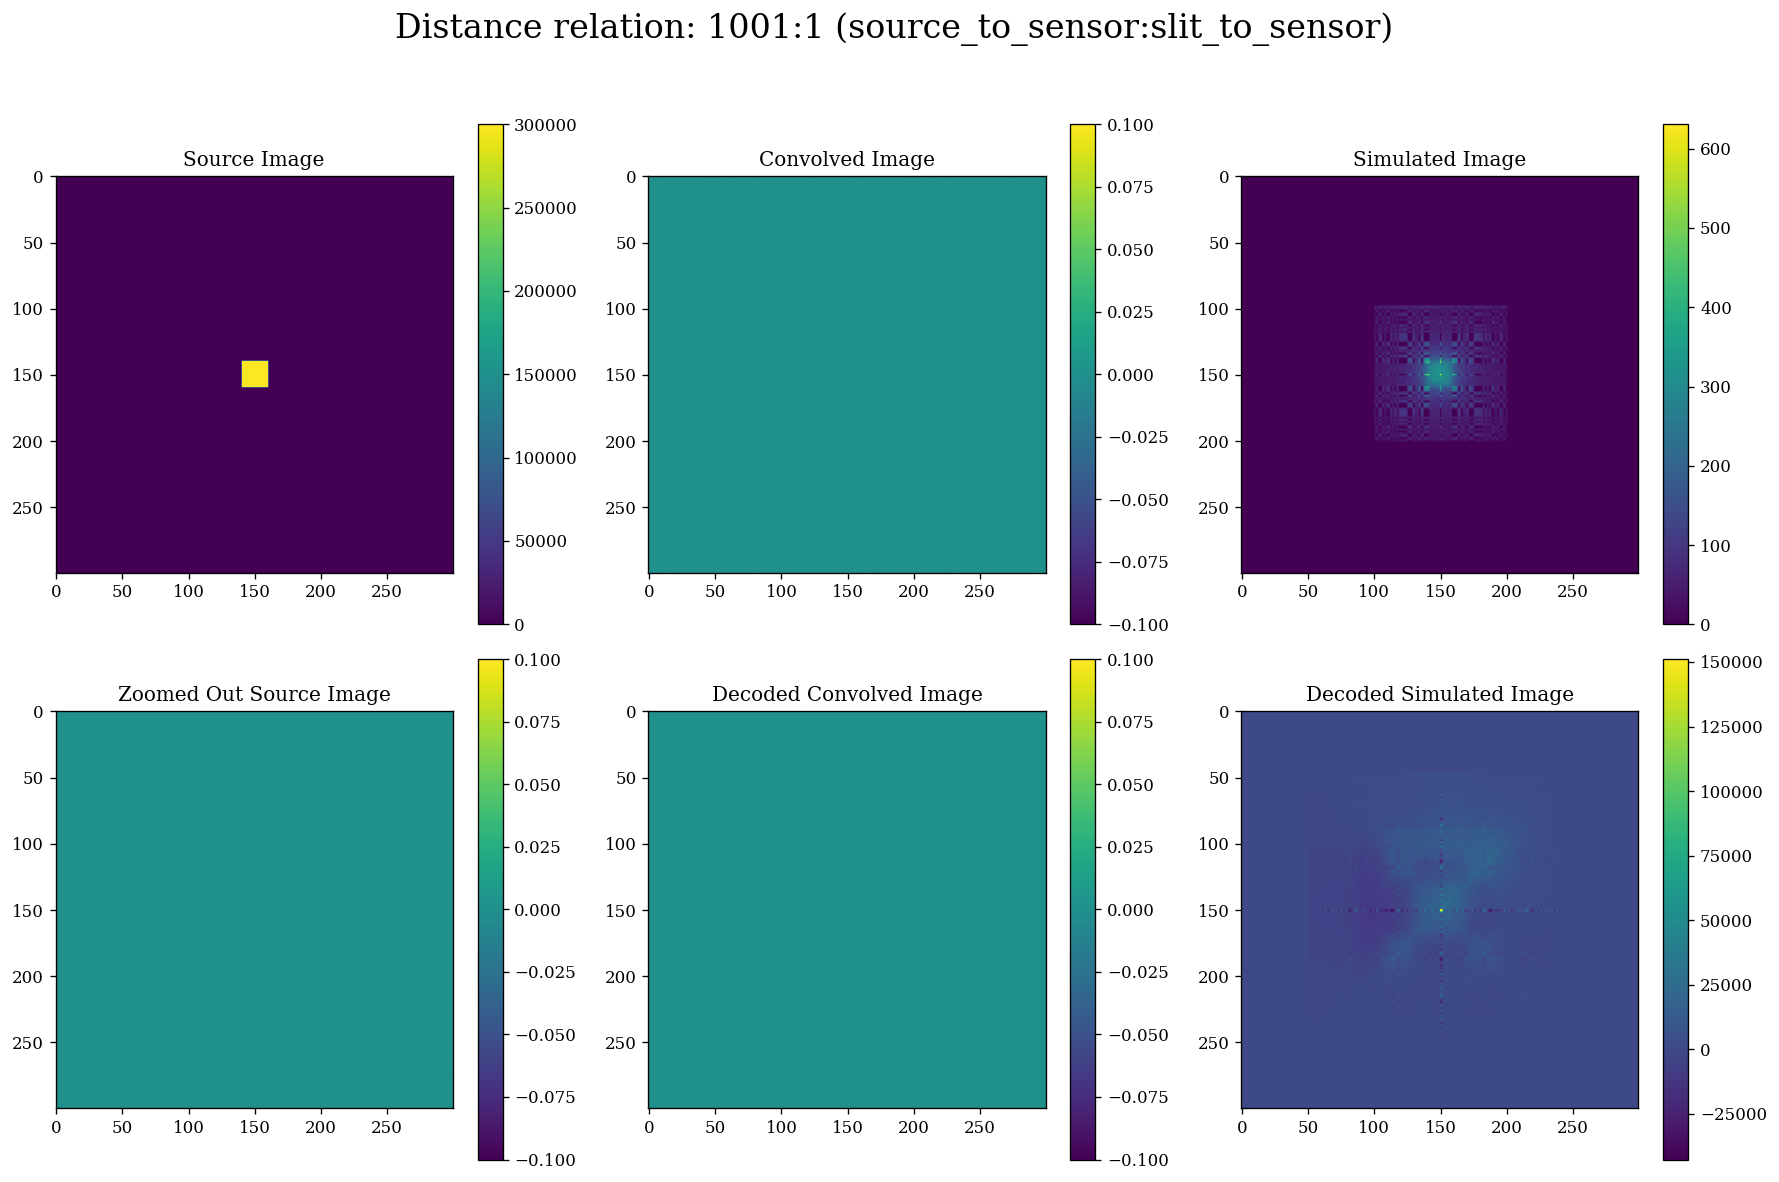

In [134]:
import pickle
with open('results/point | mura | skipper 2/simulator.pkl', 'rb') as f:
    simulator = pickle.load(f)

compare_simulation_to_convolution(
    simulator.source.screen,
    simulator.slit.mask,
    simulator.options.slit_to_sensor_distance,
    simulator.options.source_to_sensor_distance
)

### Frame Source 51:1 relationship

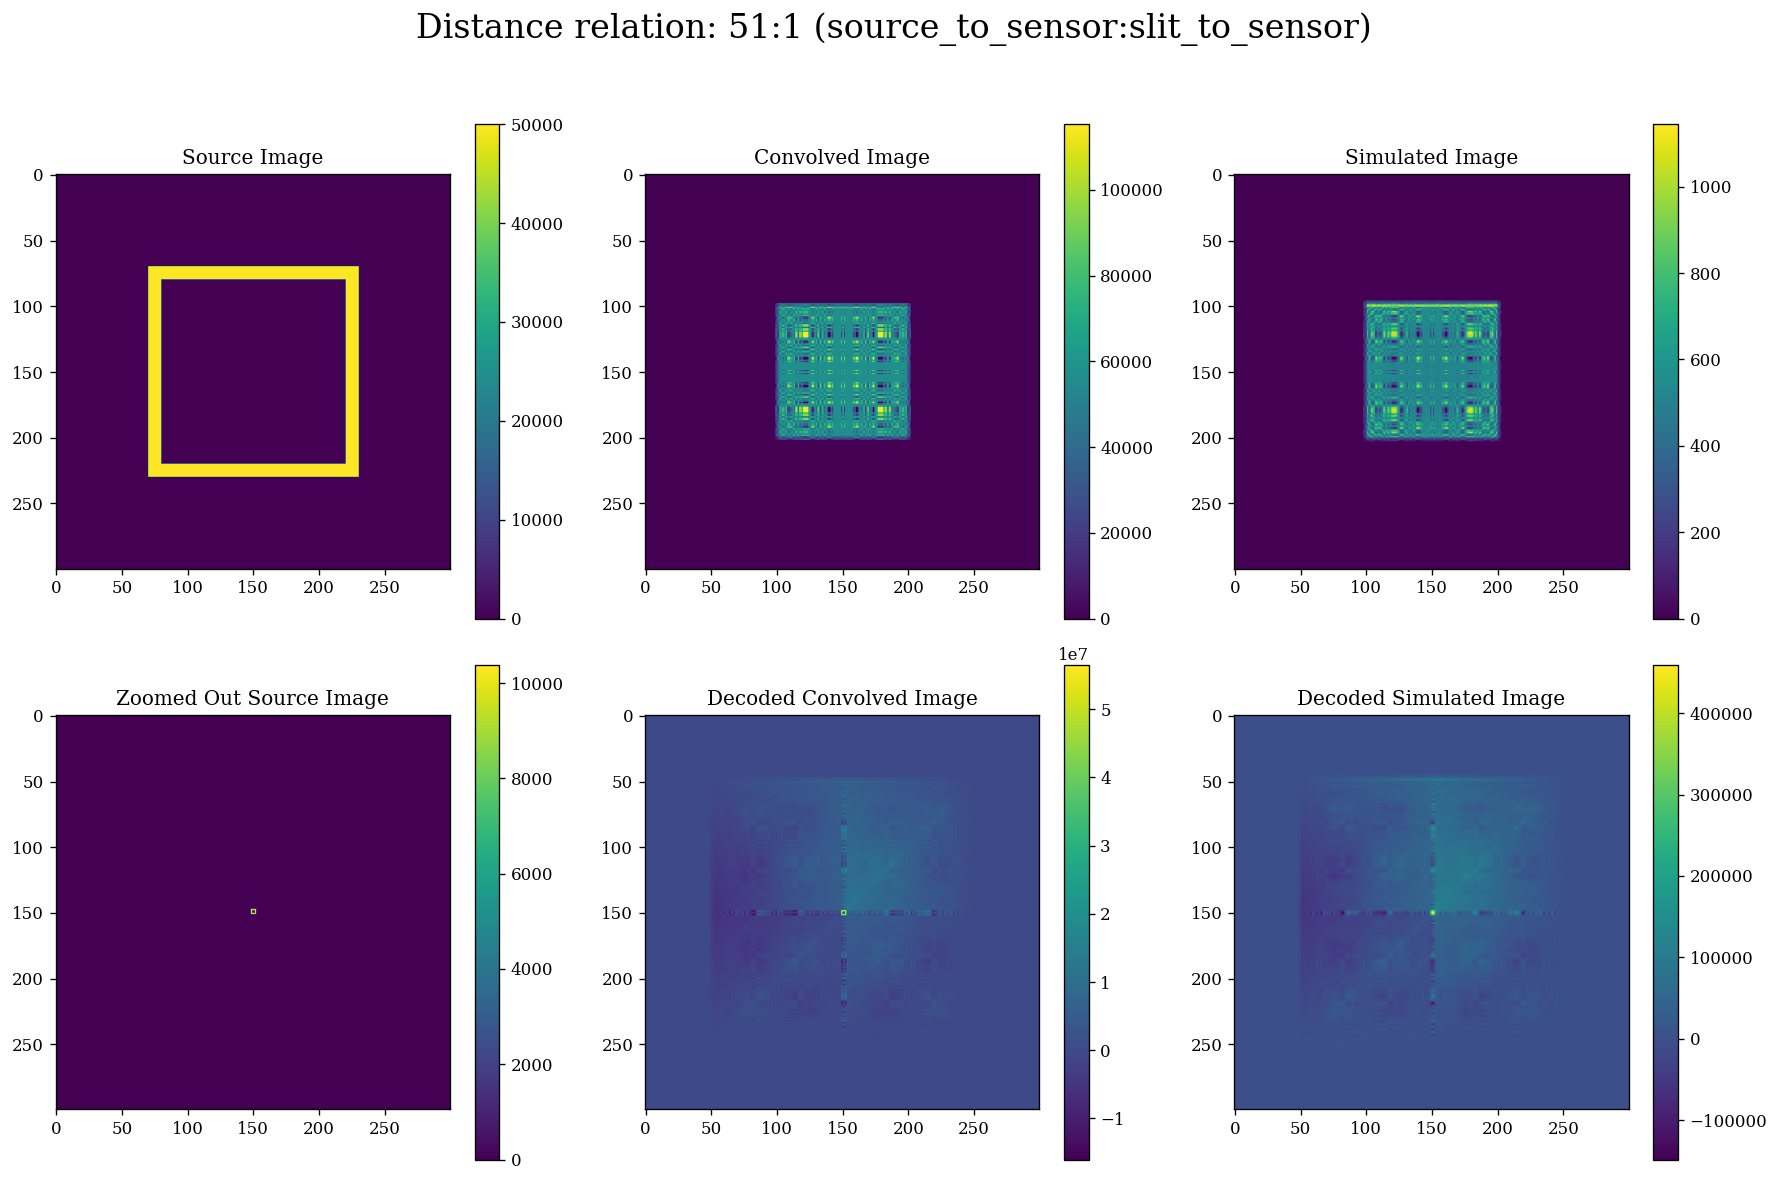

In [135]:
with open('results/frame | mura | skipper 2/simulator.pkl', 'rb') as f:
    simulator = pickle.load(f)


compare_simulation_to_convolution(
    simulator.source.screen,
    simulator.slit.mask,
    simulator.options.slit_to_sensor_distance,
    simulator.options.source_to_sensor_distance
)

### Frame Source 11:1 relationship

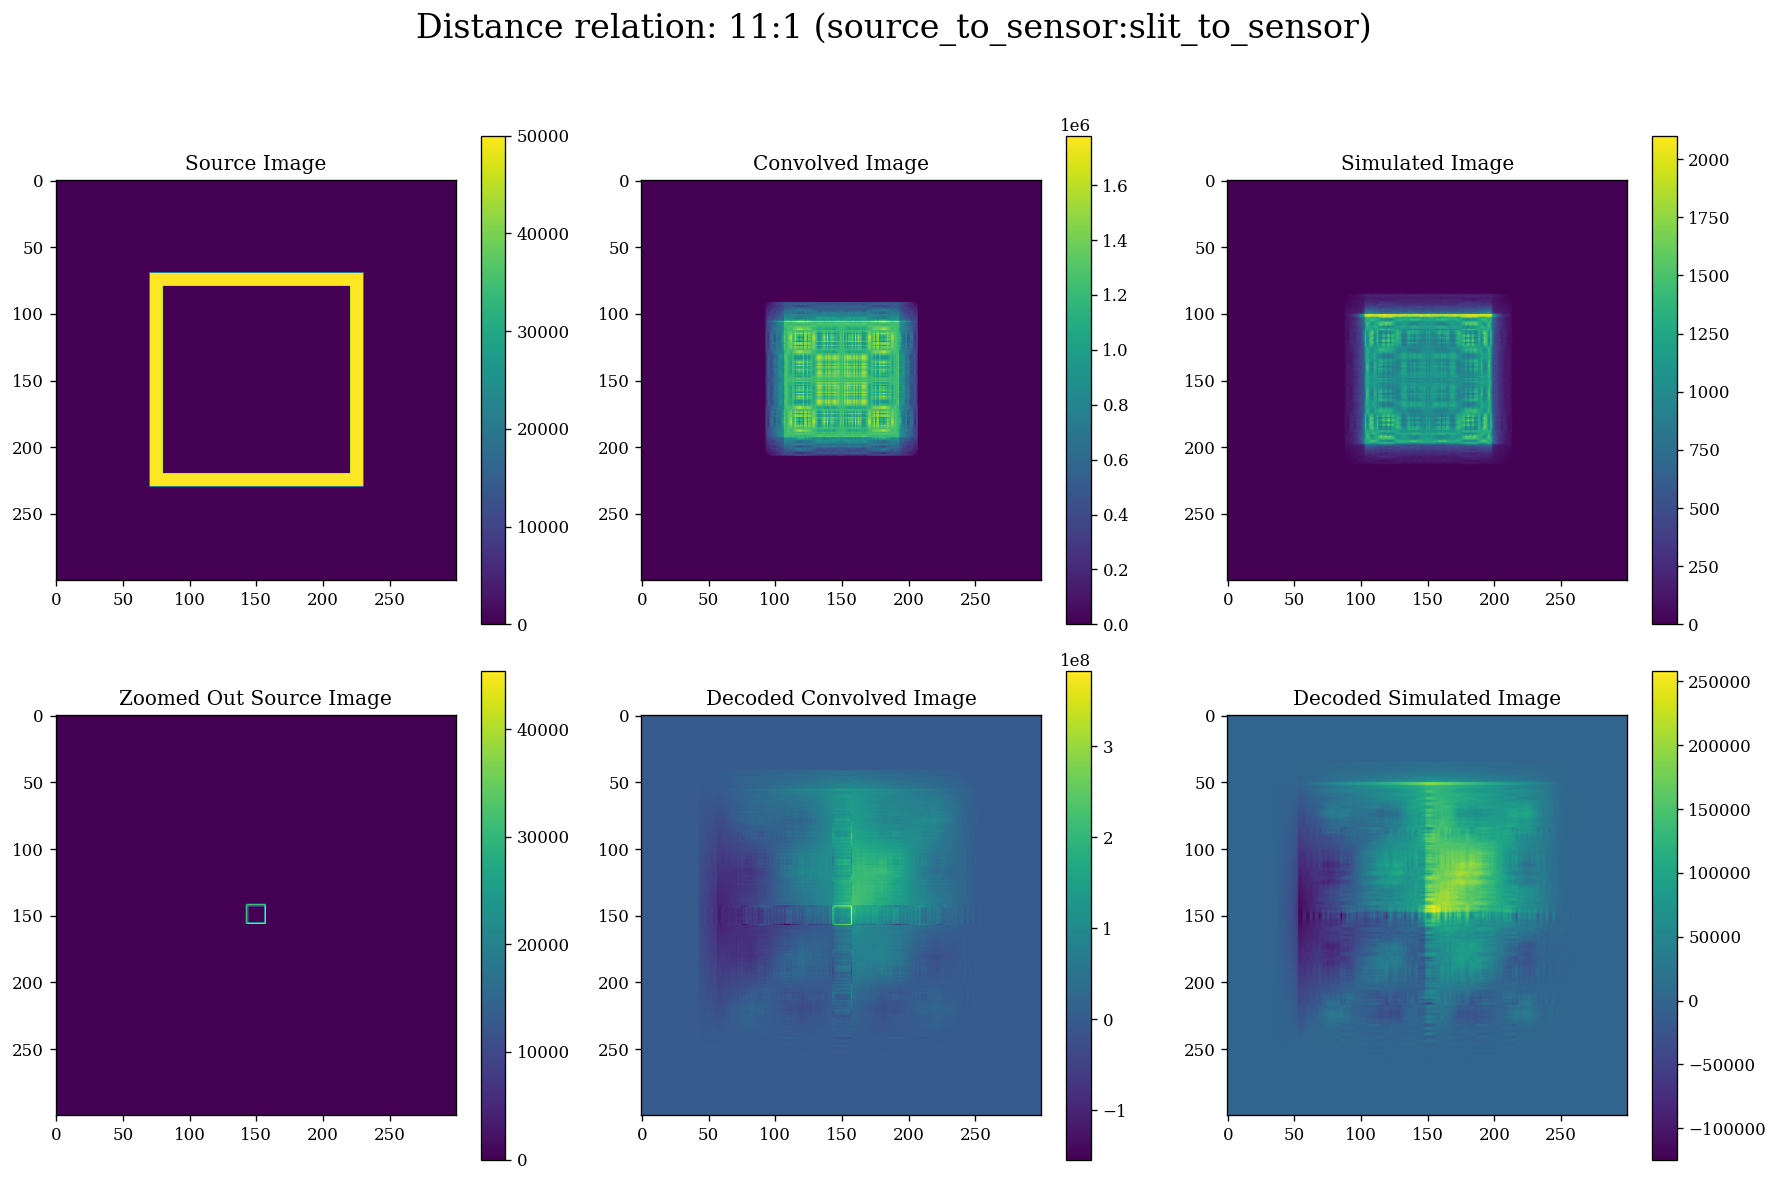

In [136]:
with open('results/frame | mura | skipper 3/simulator.pkl', 'rb') as f:
    simulator = pickle.load(f)


compare_simulation_to_convolution(
    simulator.source.screen,
    simulator.slit.mask,
    simulator.options.slit_to_sensor_distance,
    simulator.options.source_to_sensor_distance
)

### Frame Source 6:1 relationship

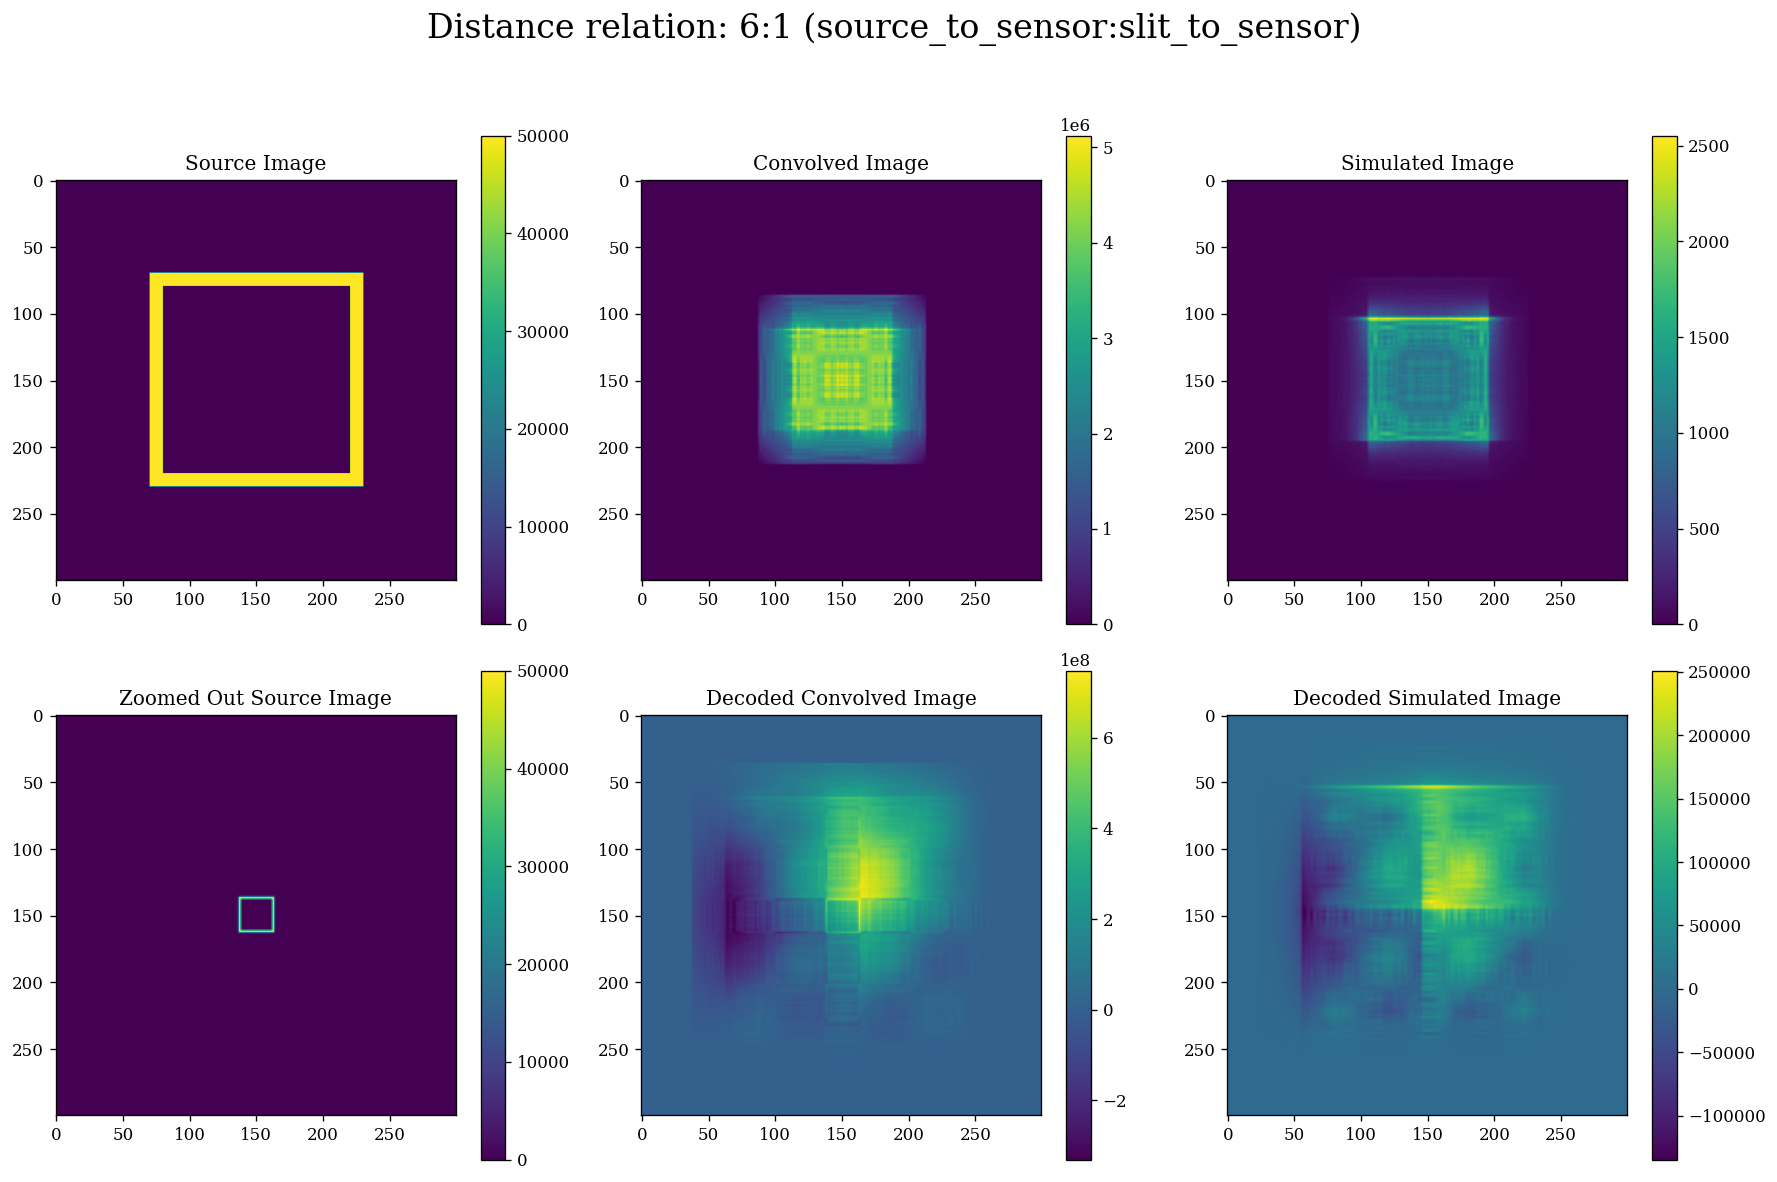

In [137]:
with open('results/frame | mura | skipper 4/simulator.pkl', 'rb') as f:
    simulator = pickle.load(f)

compare_simulation_to_convolution(
    simulator.source.screen,
    simulator.slit.mask,
    simulator.options.slit_to_sensor_distance,
    simulator.options.source_to_sensor_distance
)

### Dog Source 11:1 Relationship

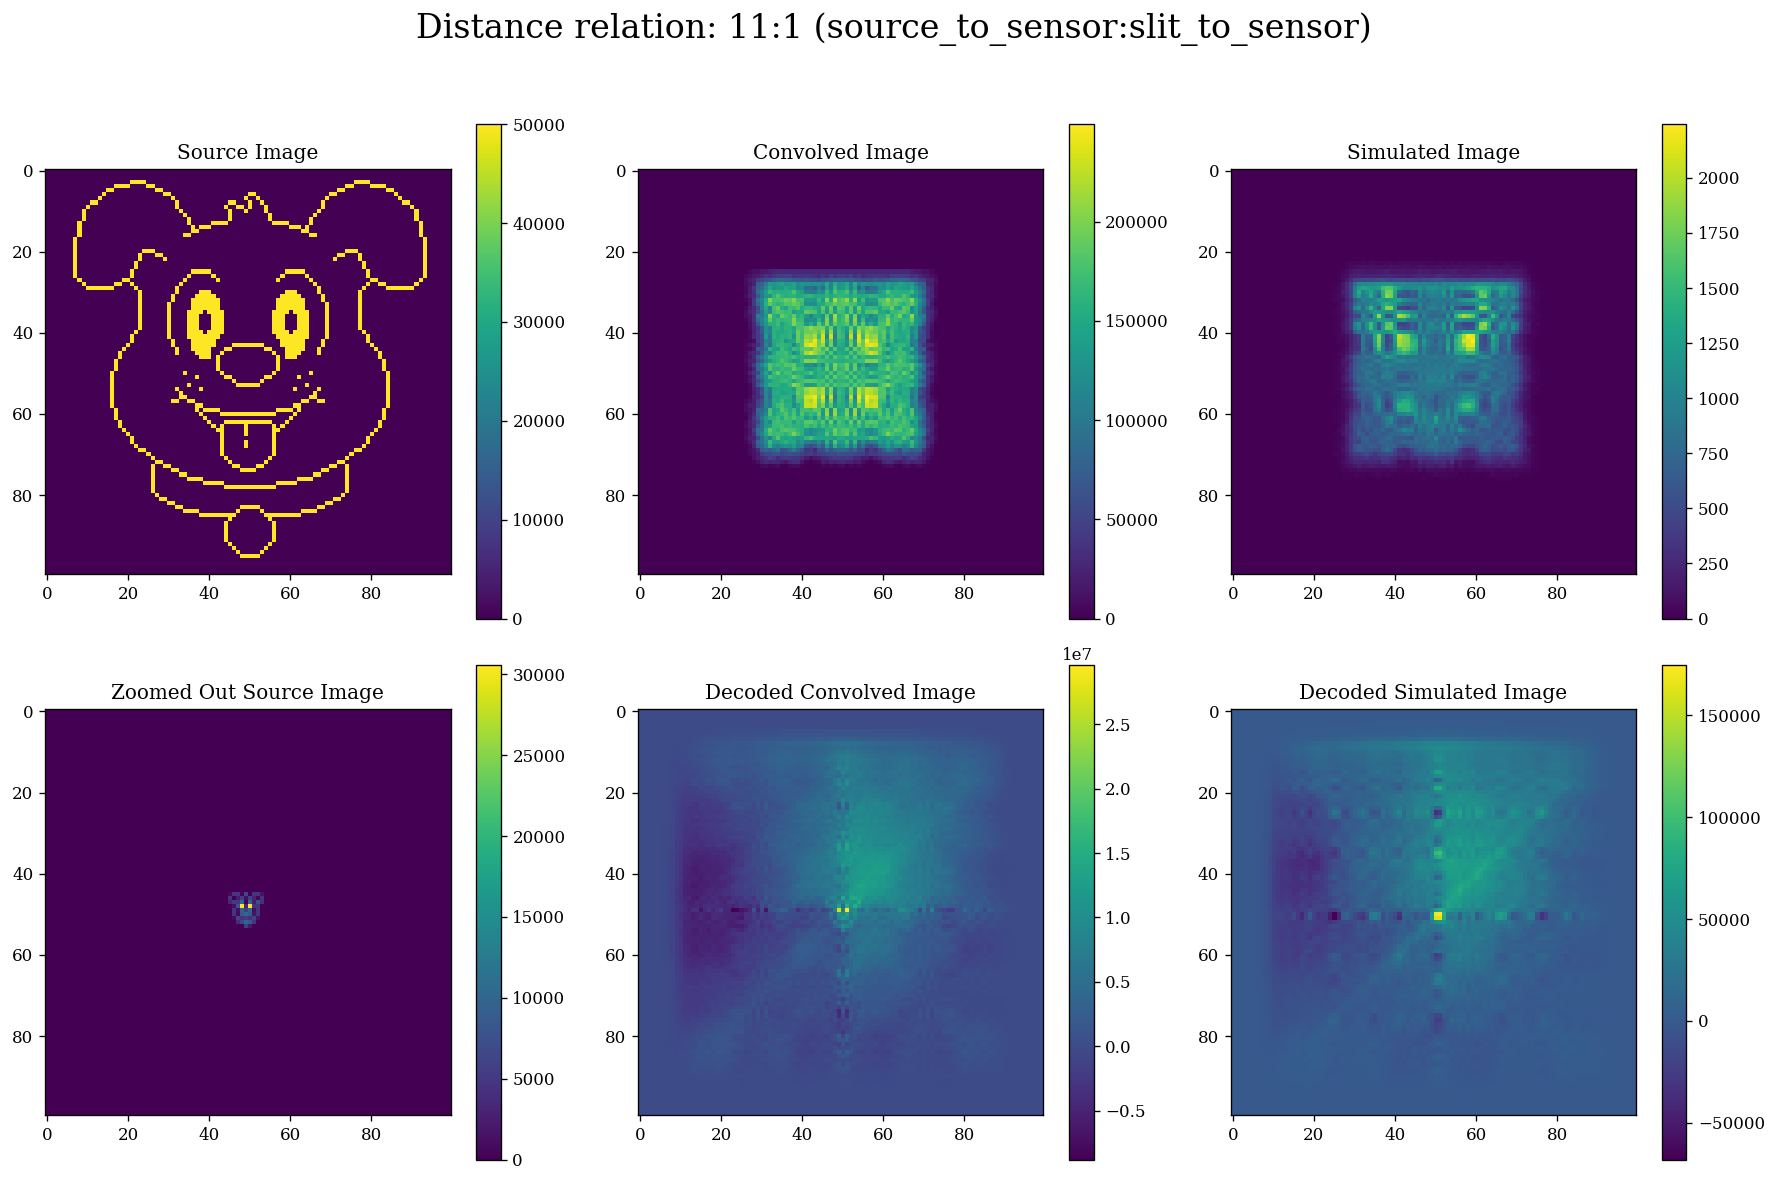

In [ ]:
with open('results/dog | mura | skipper/simulator.pkl', 'rb') as f:
    simulator = pickle.load(f)

compare_simulation_to_convolution(
    simulator.source.screen,
    simulator.slit.mask,
    simulator.options.slit_to_sensor_distance,
    simulator.options.source_to_sensor_distance
)

### Dog Source 6:1 Relationship

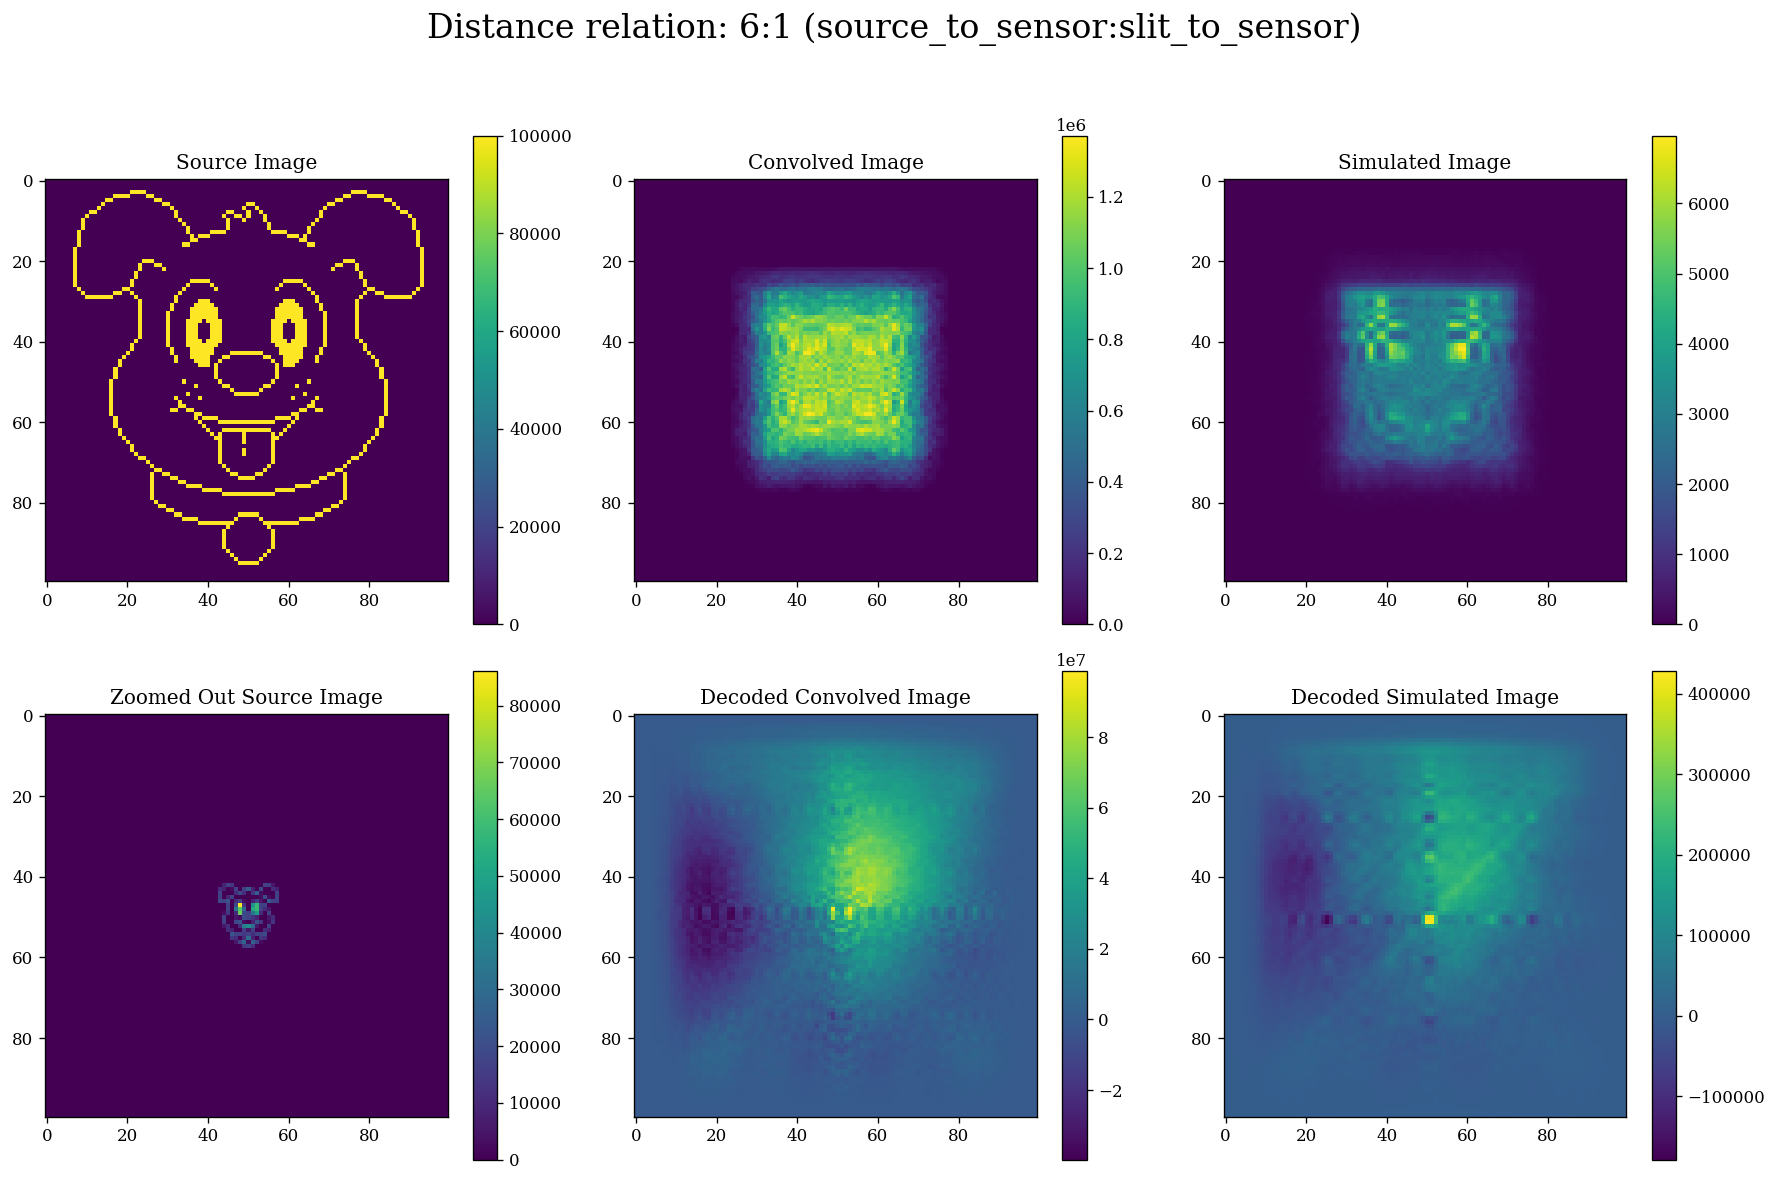

In [140]:
with open('results/dog | mura | skipper 2/simulator.pkl', 'rb') as f:
    simulator = pickle.load(f)

compare_simulation_to_convolution(
    simulator.source.screen,
    simulator.slit.mask,
    simulator.options.slit_to_sensor_distance,
    simulator.options.source_to_sensor_distance
)

### Big Phi Source 101:1 Relationship

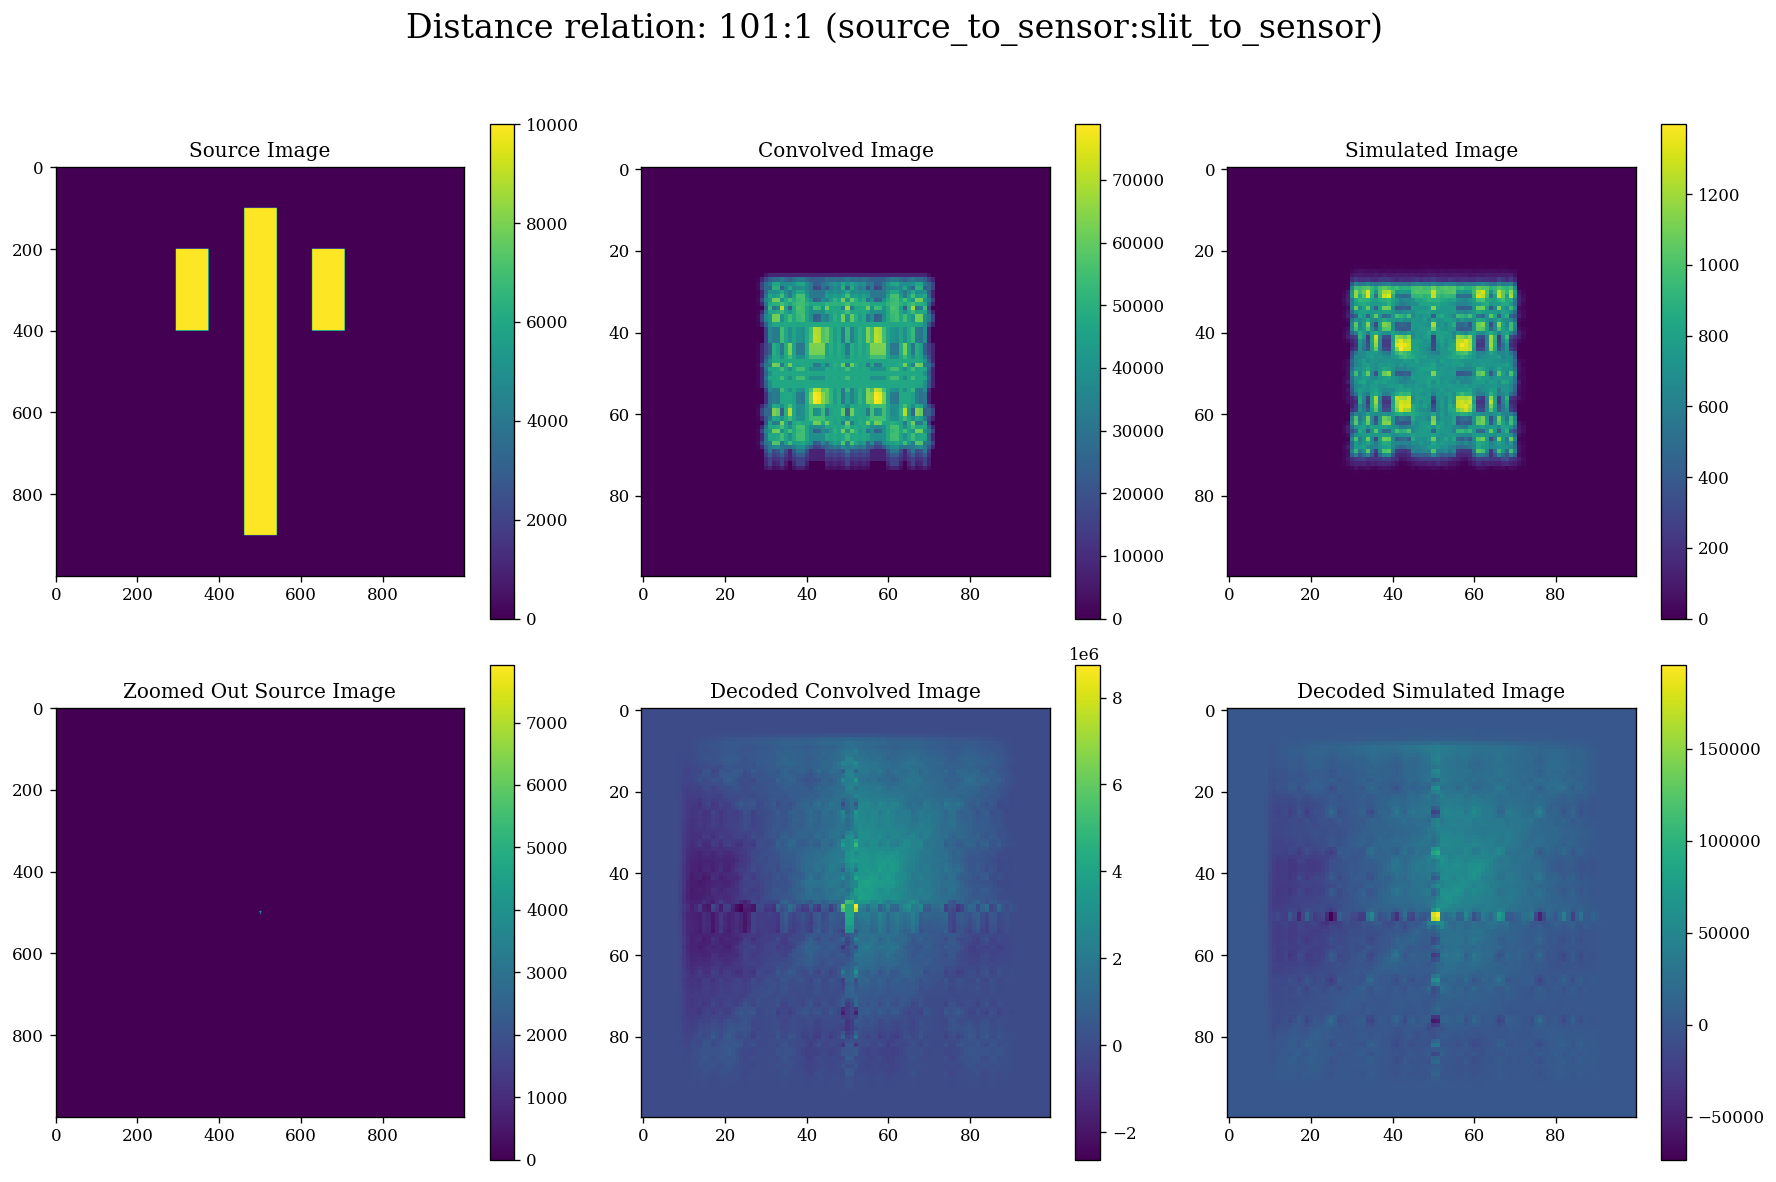

In [147]:
with open('results/phi | mura | skipper big/simulator.pkl', 'rb') as f:
    simulator = pickle.load(f)

compare_simulation_to_convolution(
    simulator.source.screen,
    simulator.slit.mask,
    simulator.options.slit_to_sensor_distance,
    simulator.options.source_to_sensor_distance
)

### Big Phi Source 51:1 Relationship

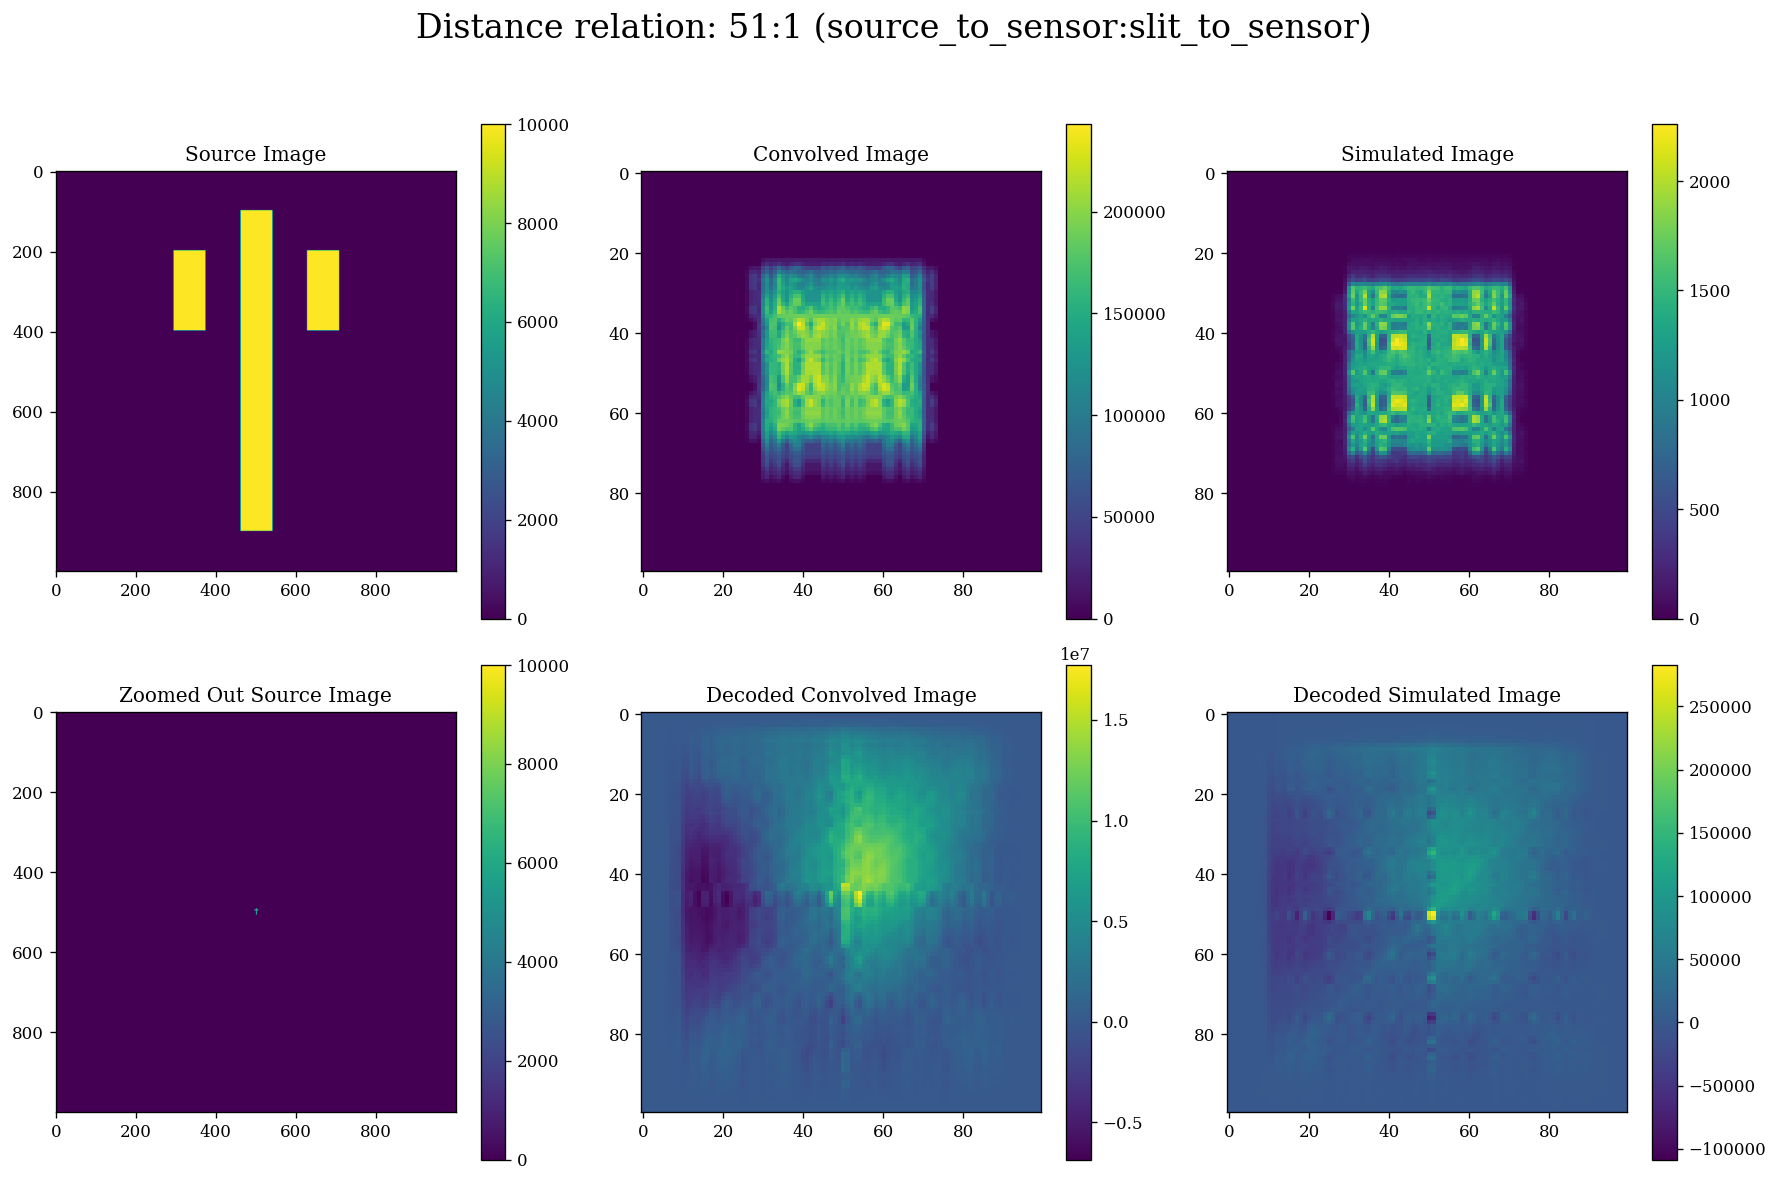

In [ ]:
with open('results/phi | mura | skipper big 2/simulator.pkl', 'rb') as f:
    simulator = pickle.load(f)

compare_simulation_to_convolution(
    simulator.source.screen,
    simulator.slit.mask,
    simulator.options.slit_to_sensor_distance,
    simulator.options.source_to_sensor_distance
)

### Big Phi Source 51:1 Relationship

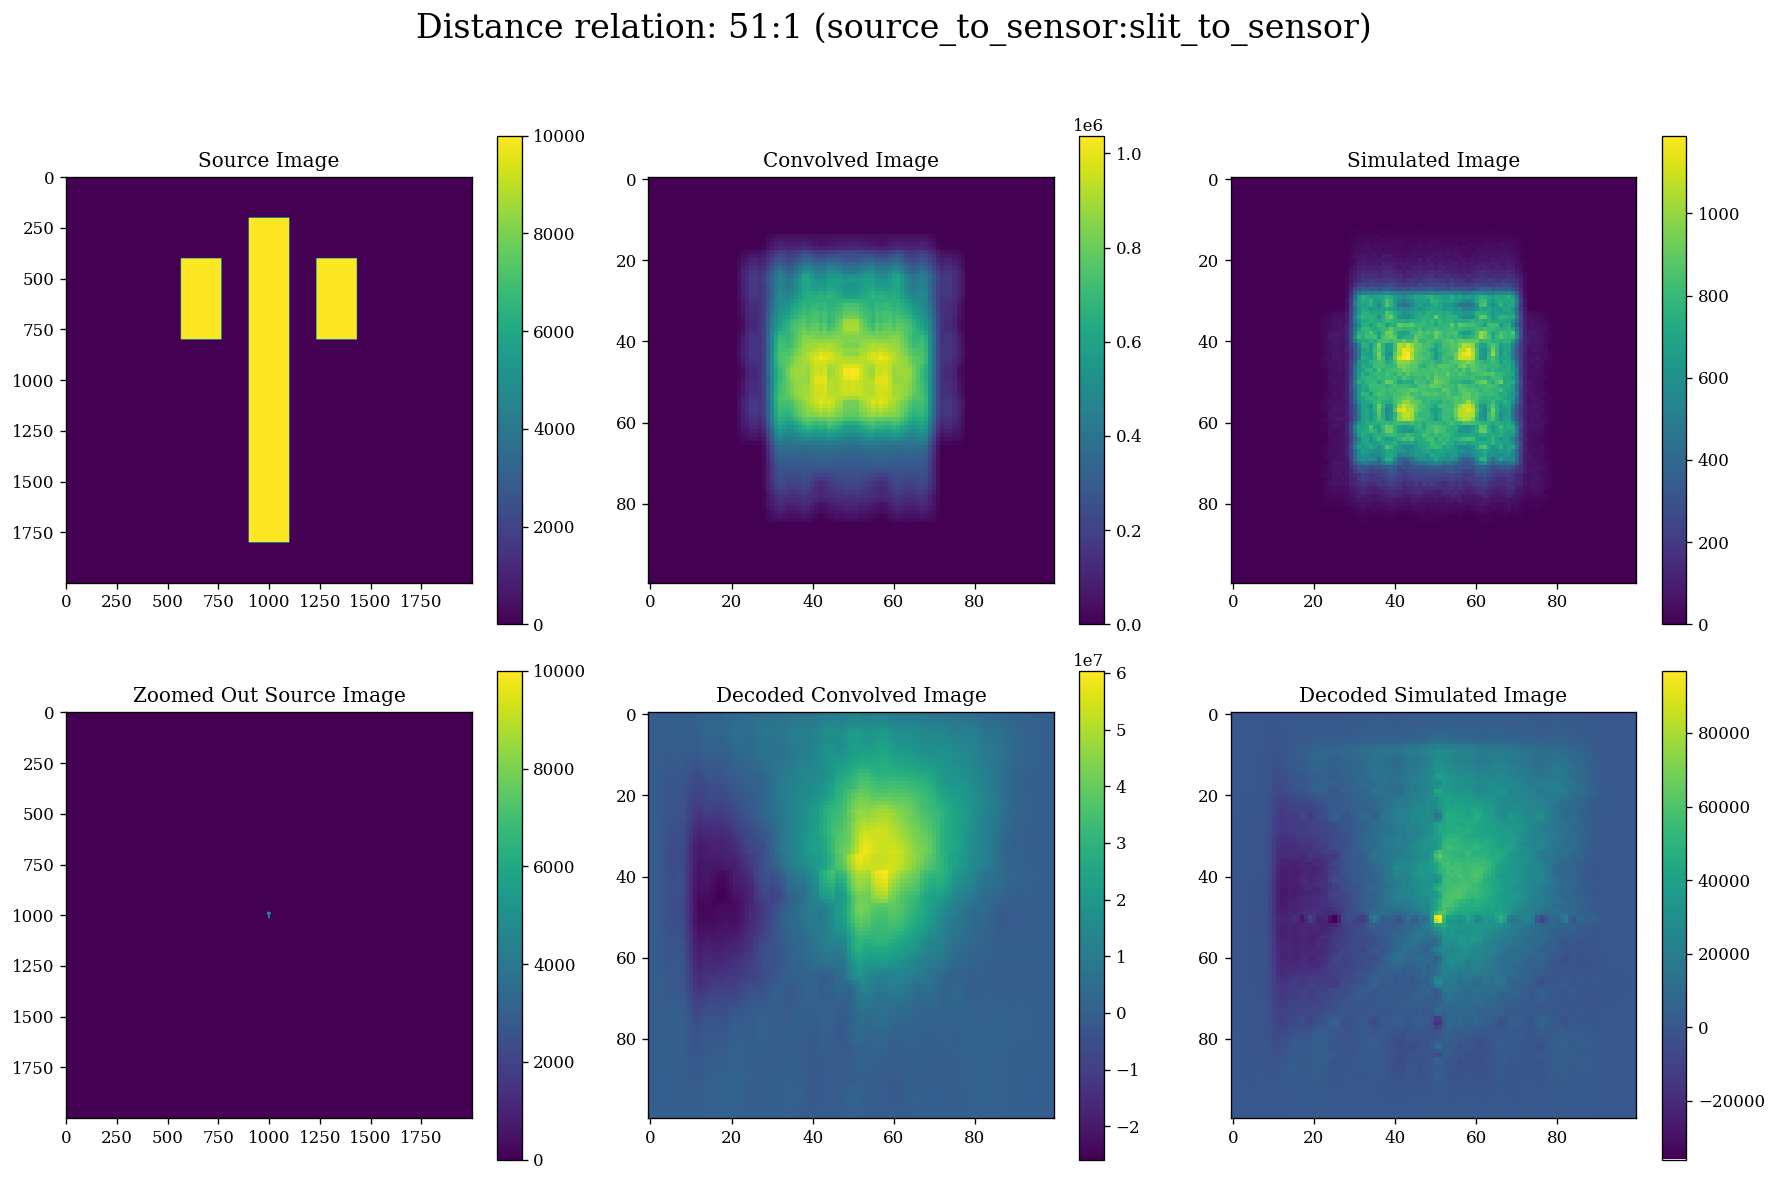

In [26]:
with open('results/phi | mura | skipper big 4/simulator.pkl', 'rb') as f:
    simulator = pickle.load(f)

zoomed_out_source_image, convolved_image, decoded_convolved_image = compare_simulation_to_convolution(
    simulator.source.screen,
    simulator.slit.mask,
    simulator.options.slit_to_sensor_distance,
    simulator.options.source_to_sensor_distance
)

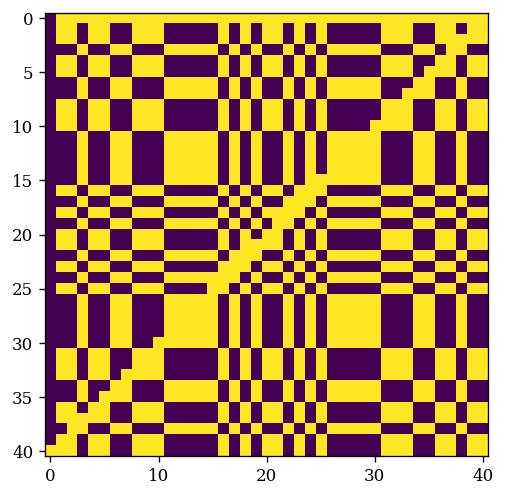

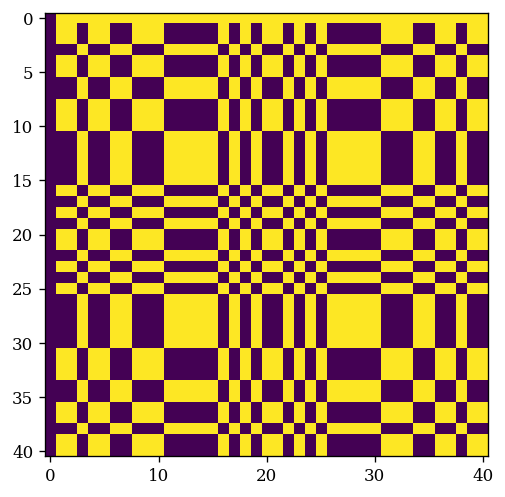

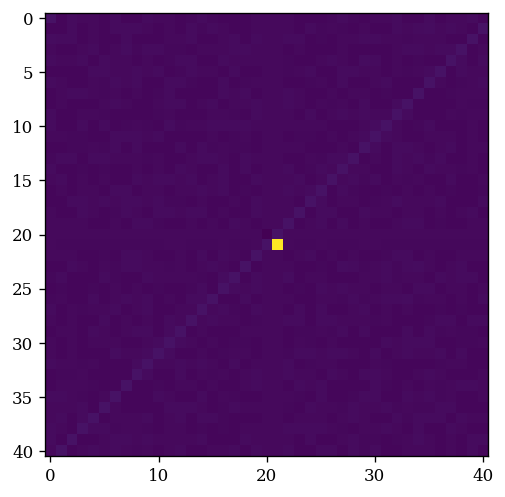

In [31]:
plt.imshow(simulator.decoding_pattern)
plt.show()
plt.imshow(simulator.slit.mask)
plt.show()
plt.imshow(convolve(simulator.decoding_pattern, simulator.slit.mask, mode='wrap'))